In [108]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import json
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from pandas.io.json import json_normalize
from textblob import TextBlob
import datetime
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

with open(r'C:\Users\AdminCOOP\Documents\GitHub\nlp_challege\articles.json', 'r', encoding="utf-8") as json_file:
   json_work = json.load(json_file)

df = pd.io.json.json_normalize(json_work)


# Analysing the Data

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39109 entries, 0 to 39108
Data columns (total 28 columns):
article_id                        39109 non-null object
authors                           24397 non-null object
contents                          39109 non-null object
excerpt                           39109 non-null object
fb_data.comments                  39109 non-null int64
fb_data.fb_overperforming         4342 non-null float64
fb_data.likes                     39109 non-null int64
fb_data.shares                    39109 non-null int64
fb_data.total_engagement_count    39109 non-null int64
has_video                         39109 non-null bool
headline                          39109 non-null object
image_link                        39109 non-null object
keywords                          39109 non-null object
li_data.li_count                  39109 non-null int64
link                              39109 non-null object
max_velocity                      39109 non-null float64
p

There is a mix of both categorical and numeric variables that are present within the dataset. We're going to isolate the numeric variables to see if we can find a correlation between them.

## Correlation Heatmap

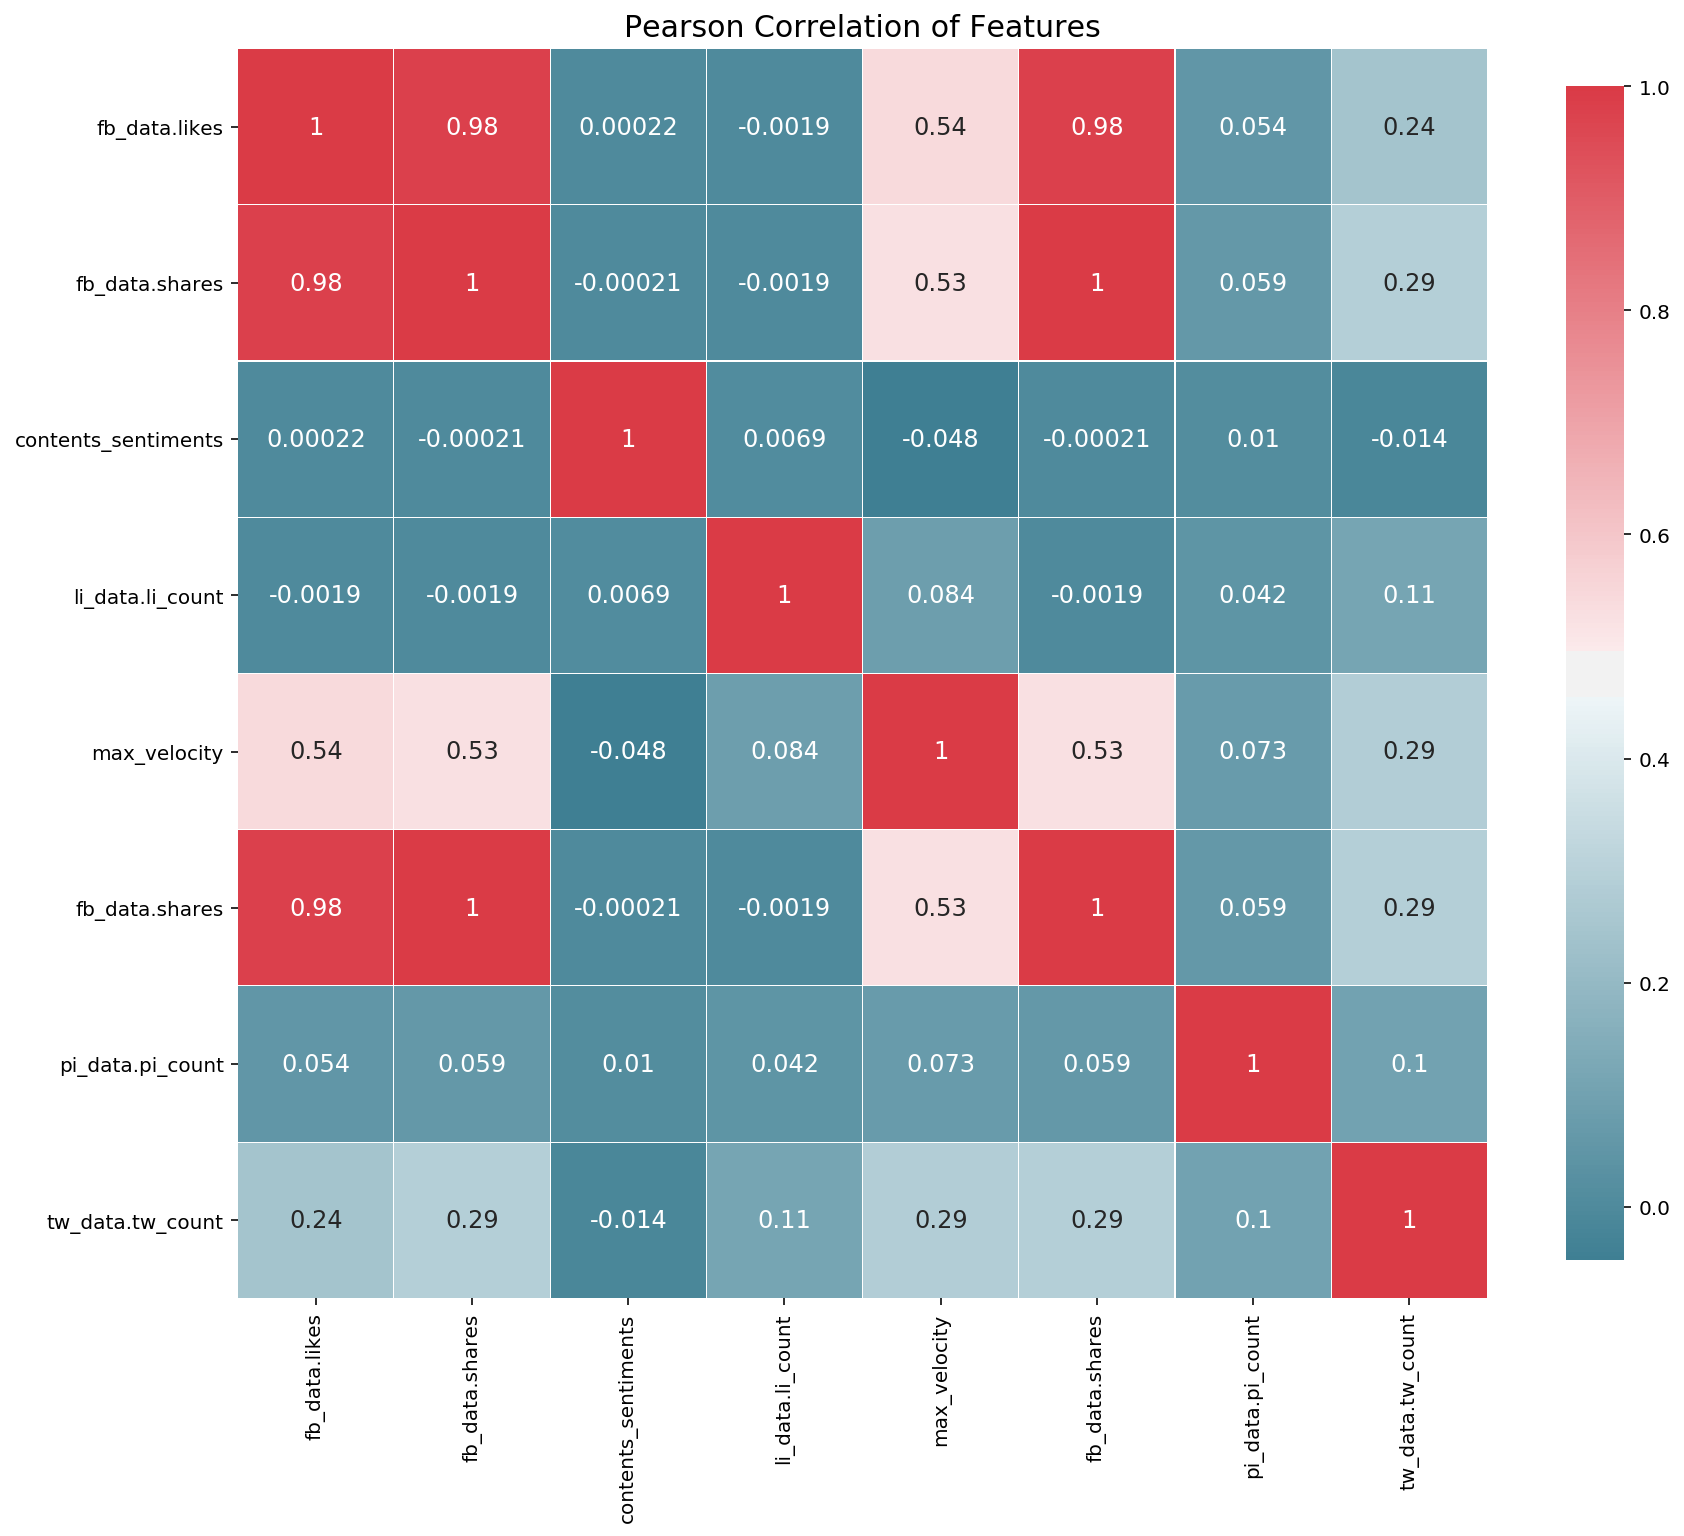

In [154]:
df_num = df[['fb_data.likes', 'fb_data.shares','contents_sentiments','li_data.li_count', 'max_velocity', 'fb_data.shares','pi_data.pi_count', 'tw_data.tw_count' ]]
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(df_num)


# Analysing by Source 

In [126]:
a = len(df['source.country'].unique())

print("There are", a, " countries that are listed within the dataset.")

b = len(df['source.publisher'].unique())

print("There are", b, " unique publishers that are listed within the dataset.")

df_source = df[['source.country', 'source.publisher', 'source.country_code', 'tw_data.tw_count']]

There are 89  countries that are listed within the dataset.
There are 3763  unique publishers that are listed within the dataset.


# Time Series Analysis

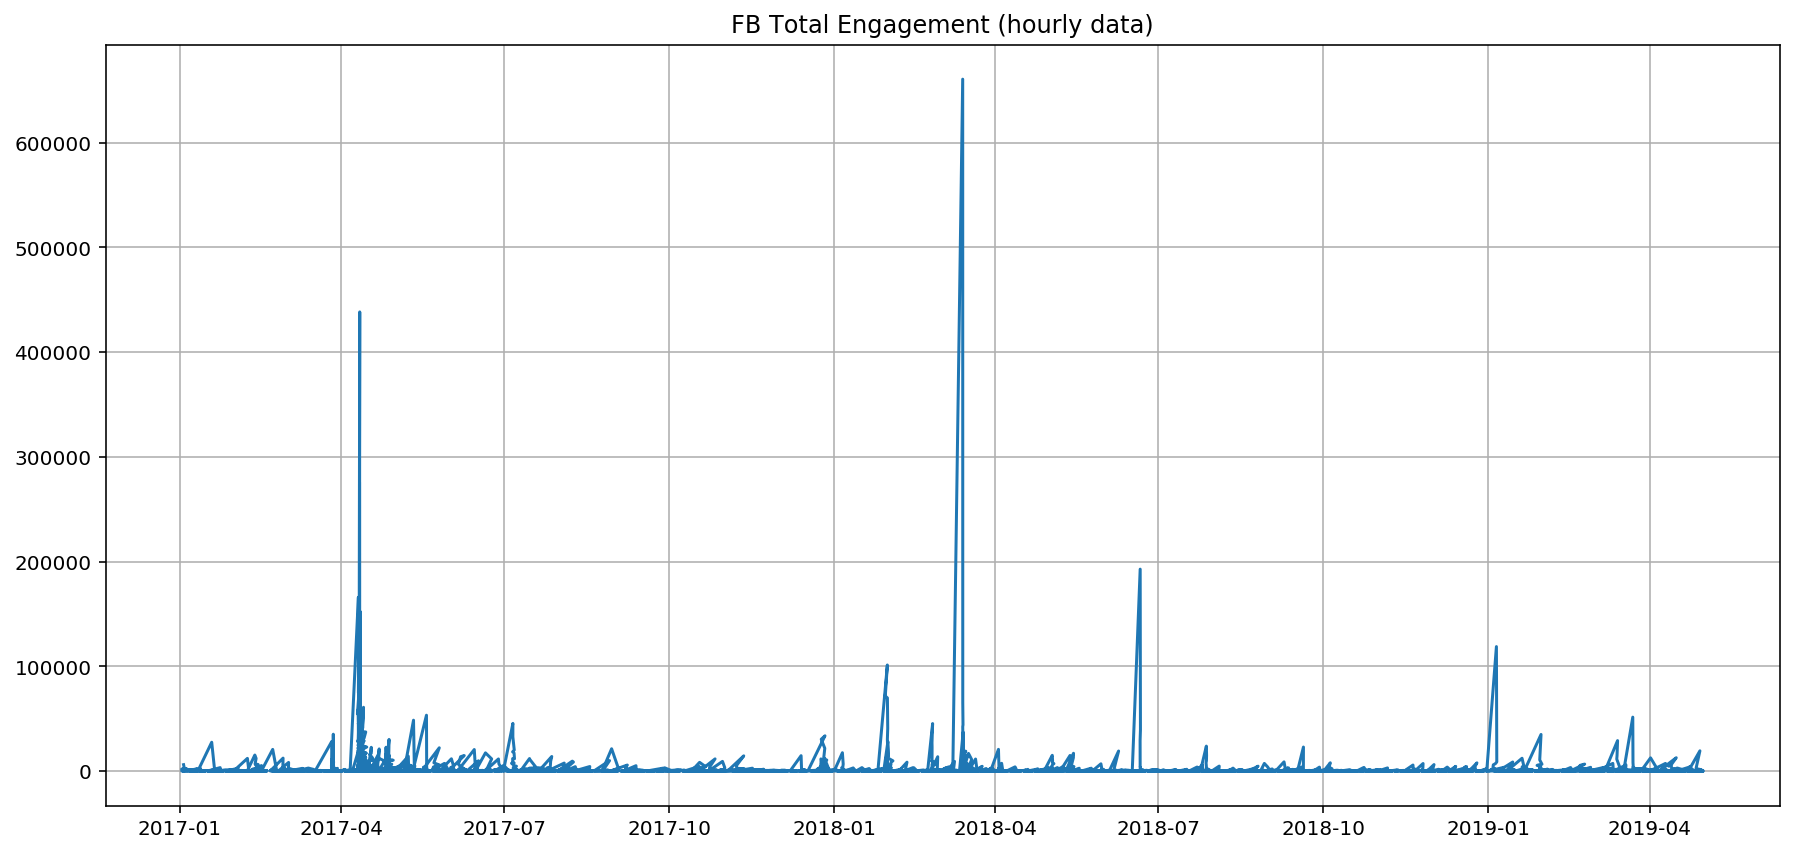

In [153]:
df1 = pd.read_csv('../nlp_challege/articles.csv', index_col=['datetime'], parse_dates=['datetime'])
plt.figure(figsize=(15, 7))
plt.plot(df1['fb_data.total_engagement_count'])
plt.title('FB Total Engagement (hourly data)')
plt.grid(True)
plt.show()

# Time-Series Graph (FB Shares)

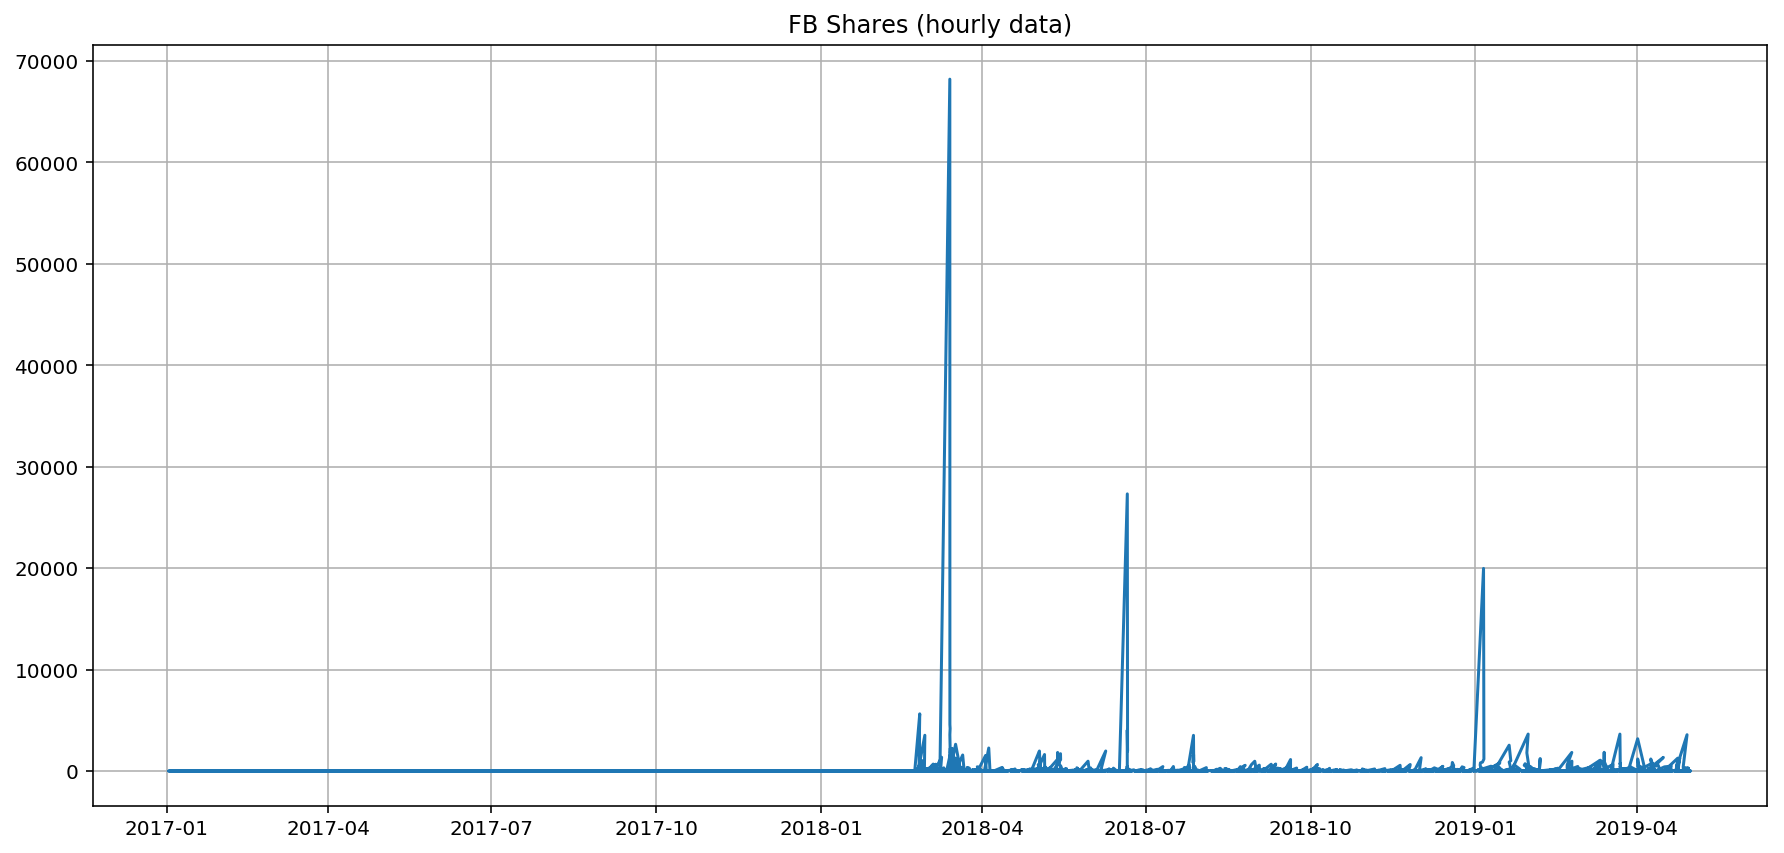

In [142]:
plt.figure(figsize=(15, 7))
plt.plot(df1['fb_data.shares'])
plt.title('FB Shares (hourly data)')
plt.grid(True)
plt.show()

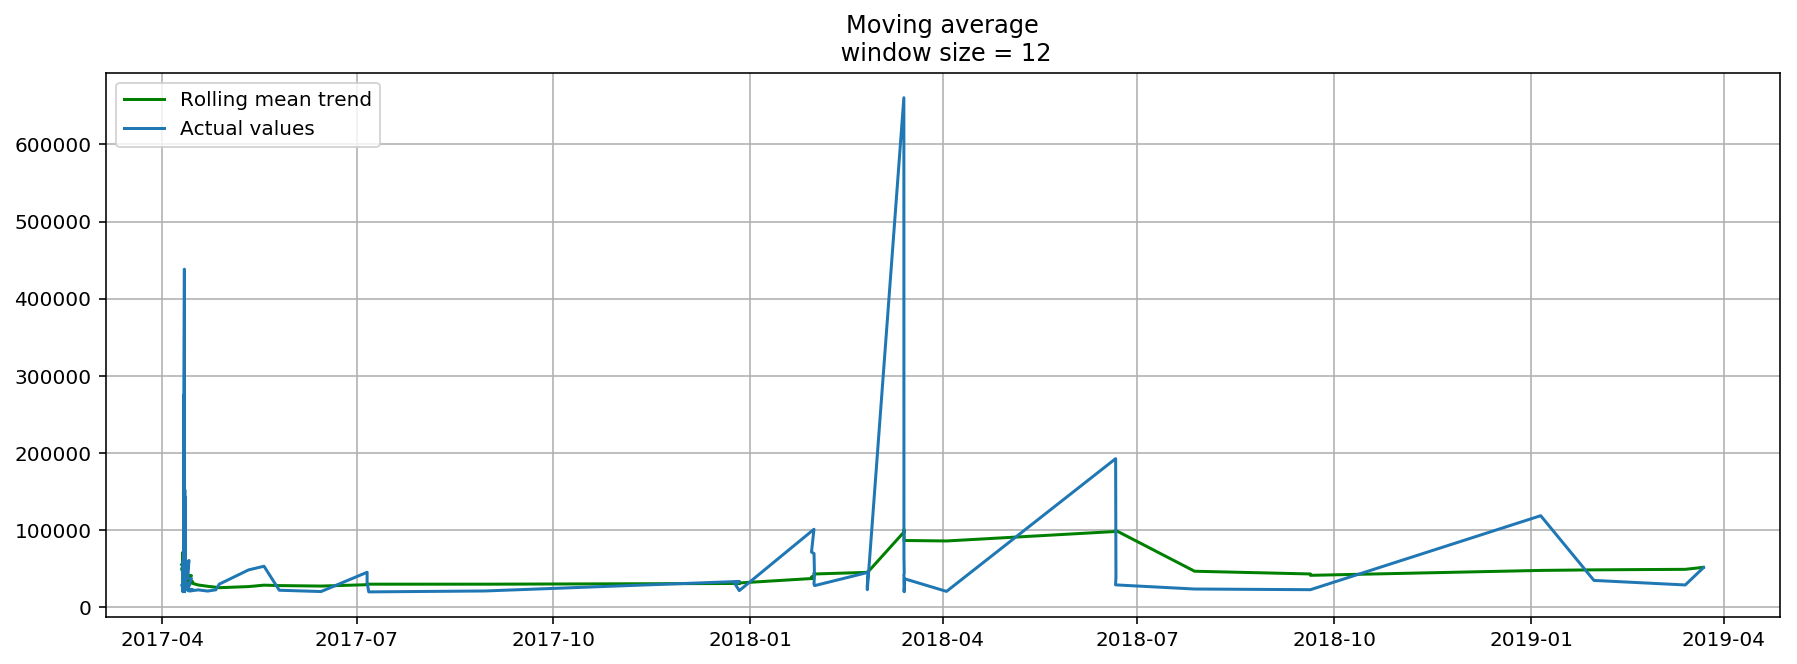

In [152]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    
df_max =  df1[df1['fb_data.total_engagement_count'] >20000]
plotMovingAverage(df_max['fb_data.total_engagement_count'], 12)

# Sentiment Analysis of Headlines

In [134]:
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

### Remove special characters 
df['headline']= df['headline'].str.replace('[^\w\s]','')
df['headline'] = df['headline'].apply(lambda x: " ".join(x.lower() for x in x.split()))
### Remove stop words 
df['headline']  = df['headline'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
#Remove the most common brand words 
df['headline'] = df['headline'].str.replace('United Airlines|united|airlines|Illinois|flight|flights|airline|dog|us|ceo|passenger|s|plane', "")


freq = pd.Series(' '.join(df['headline']).split()).value_counts()[:10]
freq = list(freq.index)
print("The top ten most frequent words in HEADLINES are:", freq)

freq1 = pd.Series(' '.join(df['headline']).split()).value_counts()[-10:]
freq1= list(freq1.index)
print("The top ten least frequent words in HEADLINES are:", freq1)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AdminCOOP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The top ten most frequent words in HEADLINES are: ['new', 'dragged', 'ay', 'man', 'eat', 'incident', 'video', 'dragging', 'airport', 'death']
The top ten least frequent words in HEADLINES are: ['về', 'bhl', 'hiy', 'whimical', 'dineyland', 'rediffcom', 'etado', 'examining', 'refilebrief', 'pinning']


# Plotting the Distribution of Shares, Likes and Engagement

Text(0, 0.5, '# Per Article Mention')

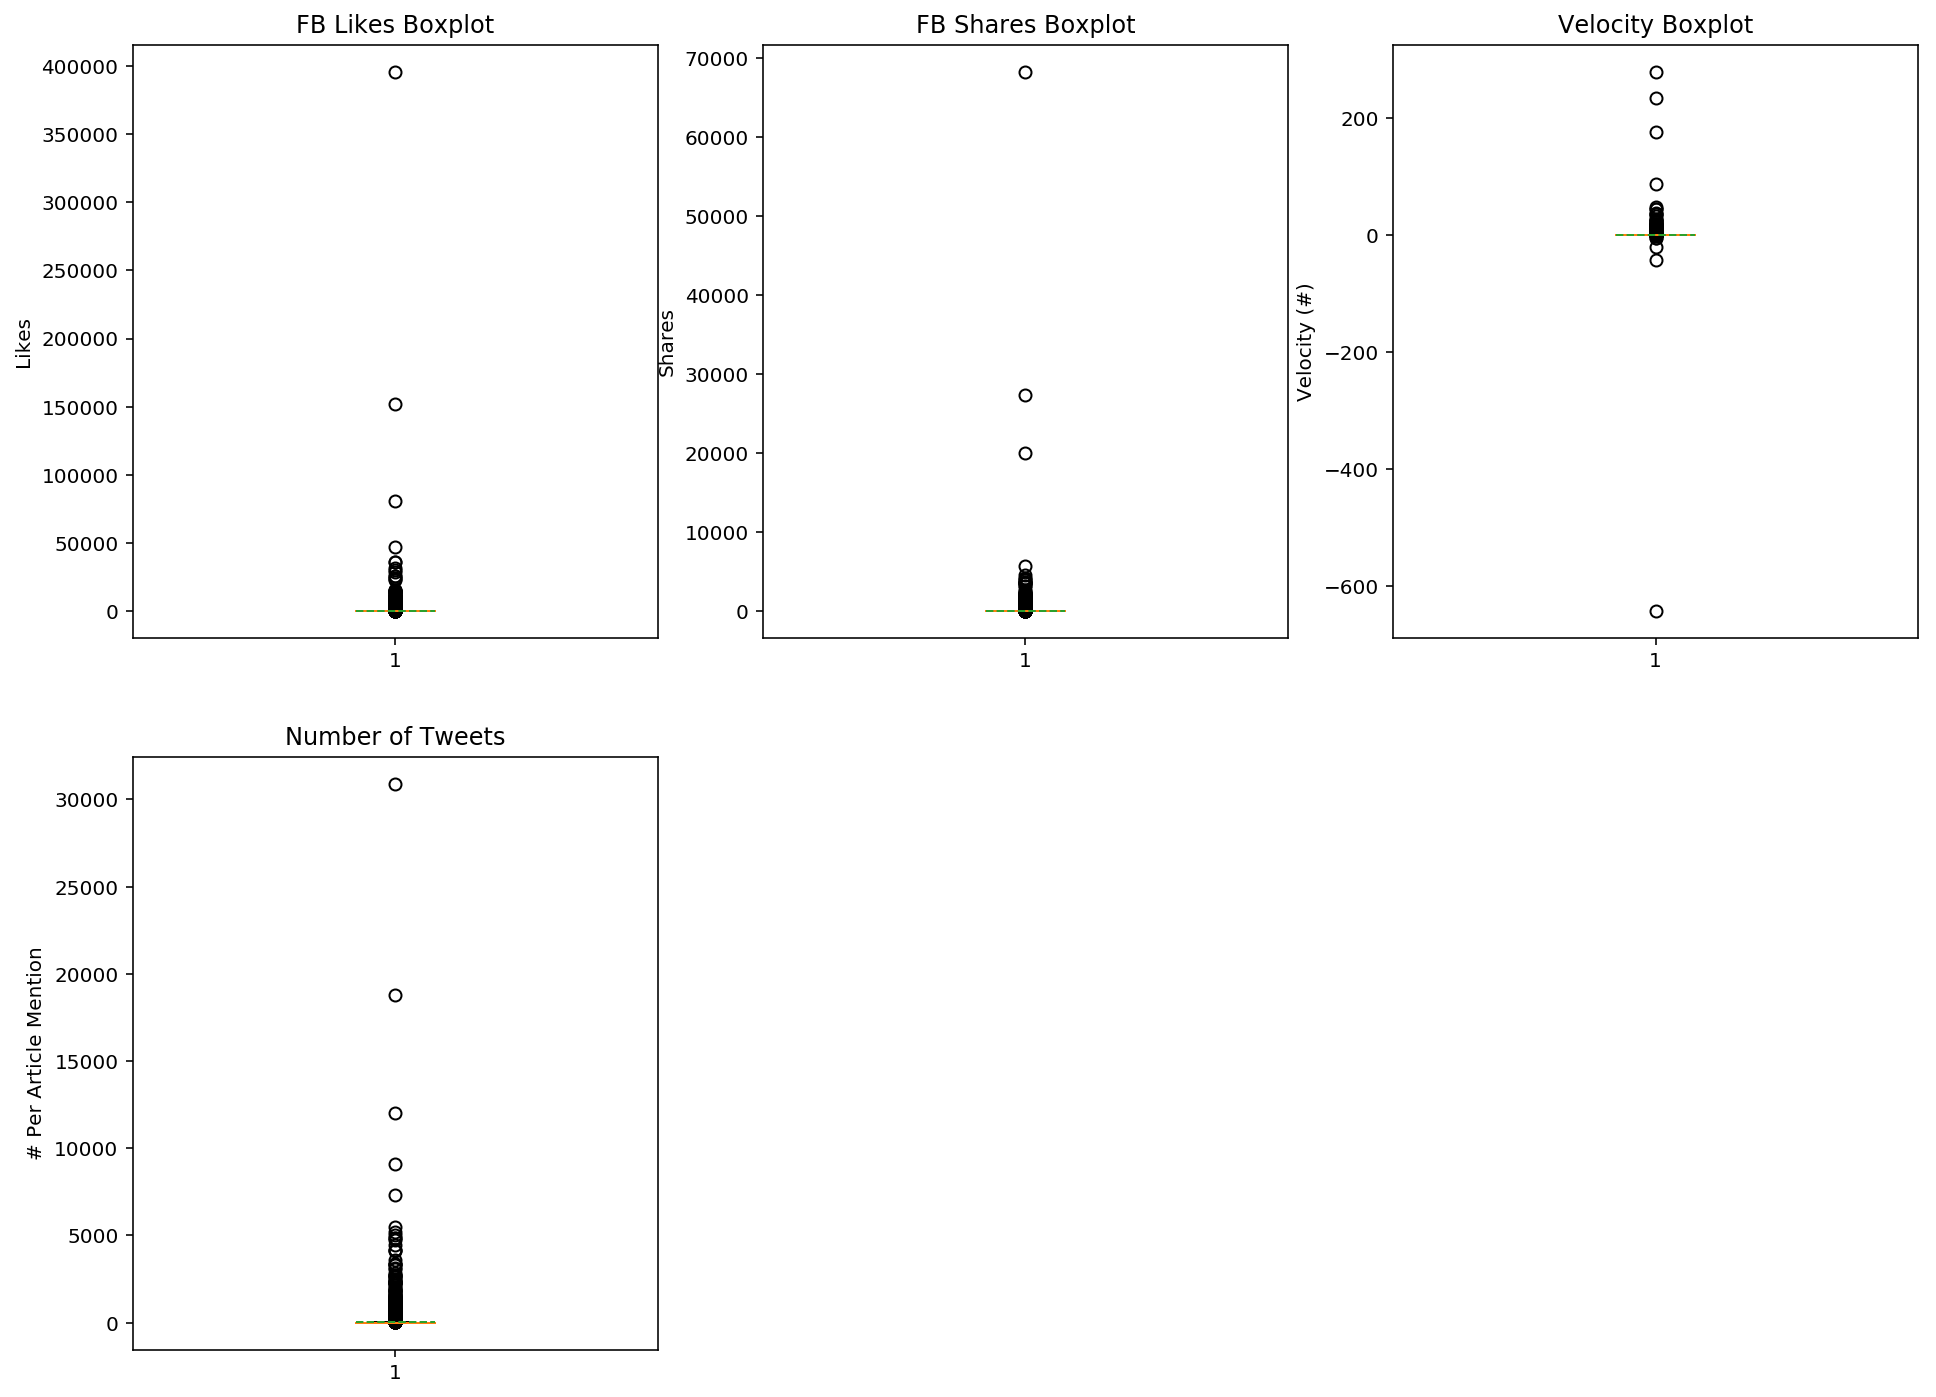

In [80]:
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=df['fb_data.likes'], showmeans = True, meanline = True)
plt.title('FB Likes Boxplot')
plt.ylabel('Likes')

plt.subplot(232)
plt.boxplot(df['fb_data.shares'], showmeans = True, meanline = True)
plt.title('FB Shares Boxplot')
plt.ylabel('Shares')

plt.subplot(233)
plt.boxplot(df['velocity'], showmeans = True, meanline = True)
plt.title('Velocity Boxplot')
plt.ylabel('Velocity (#)')

plt.subplot(234)
plt.boxplot(df['tw_data.tw_count'], showmeans = True, meanline = True)
plt.title('Number of Tweets')
plt.ylabel('# Per Article Mention')



# Ridge/LASSO Regression 
### For model feature selection. 

In [67]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

df_num = df[['fb_data.likes', 'fb_data.shares','contents_sentiments','li_data.li_count', 'max_velocity', 'fb_data.shares','pi_data.pi_count', 'tw_data.tw_count' ]]

In [68]:
y = df['velocity']

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, df_num, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

model_ridge = Ridge()

y = df.sentiment
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

The min RMSE is: 0.4377539895440764


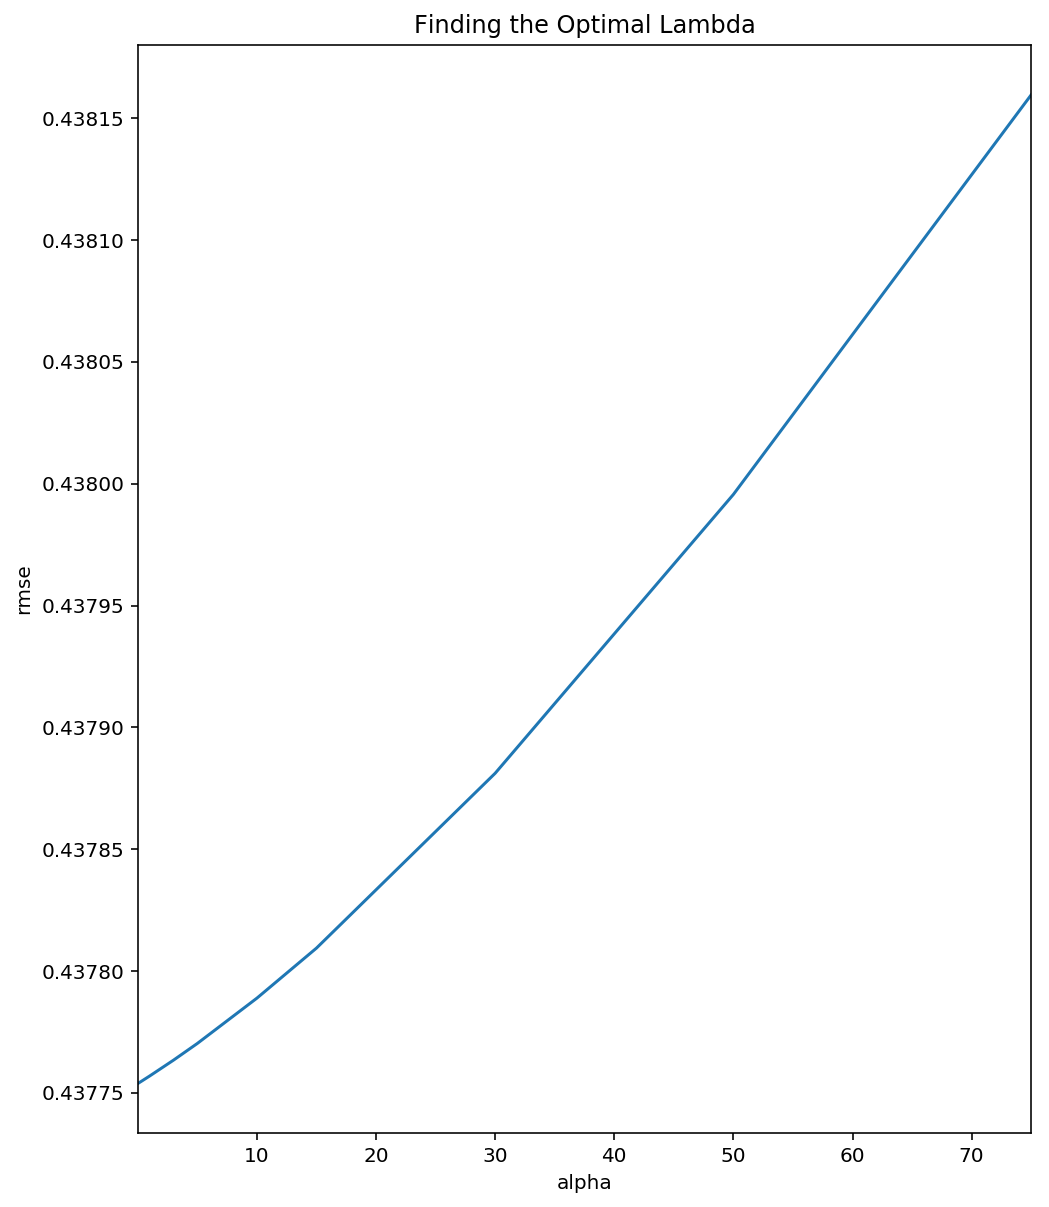

In [69]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Finding the Optimal Lambda")
plt.xlabel("alpha")
plt.ylabel("rmse")
print("The min RMSE is:",cv_ridge.min())

In [70]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(df_num, y)
rmse_cv(model_lasso).mean()


C:\Users\AdminCOOP\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\AdminCOOP\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\AdminCOOP\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\AdminCOOP\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on t

0.4378510983960541

The LASSO model performs roughly as good as the Ridge Regression

In [71]:
coef = pd.Series(model_lasso.coef_, index = df_num.columns)
print("LASSO picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

LASSO picked 8 variables and eliminated the other 0 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

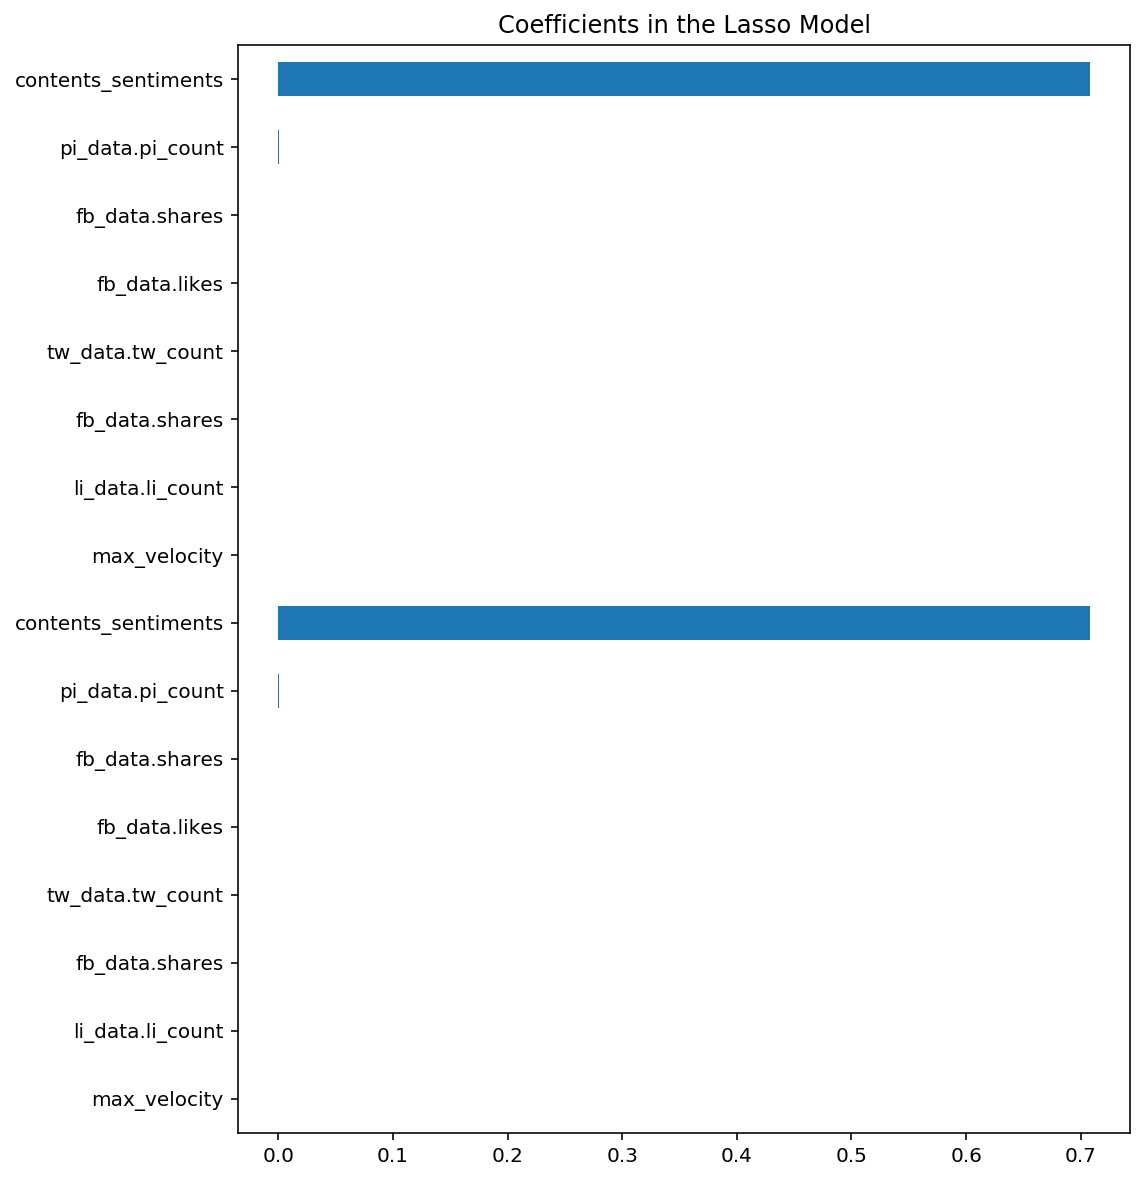

In [72]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [ ]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(df_num), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")